In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.distributions import normal, uniform
from torch.utils.data import Dataset, DataLoader

In [3]:
class NormalDataset():
    def __init__(self, size, seed=123):
        torch.manual_seed(seed)
        self.size = size
        scale = 1
        offset = 0
        
        norm = normal.Normal(4, 1)
        x = norm.sample(sample_shape=torch.Size([size, 1]))
        self.points = x
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.points[idx]
        return sample

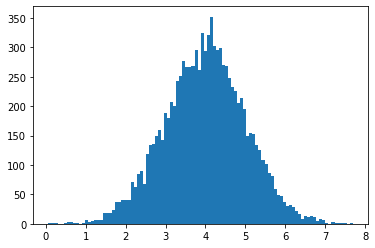

In [4]:
norm = NormalDataset(10000)
points = norm[np.arange(10000)]
plt.hist(points.numpy()[:,0], bins=100)
plt.show()

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        hidden_size = 4
        
        self.hidden0 = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return x

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        hidden_size = 4
        
        self.hidden0 = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True)
        )

        self.hidden2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return x

In [7]:
def z_uniform(size, range_=10.0):
    unif = uniform.Uniform(-range_/2, range_/2)
    return unif.sample(sample_shape=torch.Size([size])).reshape(-1, 1)

In [8]:
def train_discriminator(real_data, gen_data, discriminator, optimizer):
    optimizer.zero_grad()
    
    real_pred = discriminator(real_data)
    real_loss = nn.BCELoss()(real_pred, torch.ones_like(real_pred))
    real_loss.backward()
    
    gen_pred = discriminator(gen_data)
    gen_loss = nn.BCELoss()(1 - gen_pred, torch.ones_like(gen_pred))
    gen_loss.backward()
    
    optimizer.step()
    
    return real_loss, gen_loss

In [9]:
def train_generator(z, generator, discriminator, optimizer):
    optimizer.zero_grad()
    
    gen_data = generator(z)
    gen_pred = discriminator(gen_data)
    gen_loss = nn.BCELoss()(gen_pred, torch.ones_like(gen_pred))
    gen_loss.backward()
    
    optimizer.step()
    
    return gen_loss

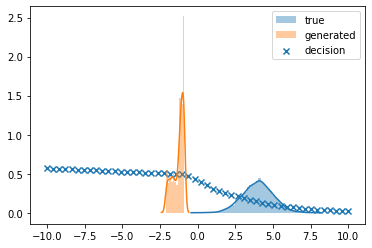

In [13]:
x_lin = torch.tensor(np.linspace(-10.0, 10.0, num=50).reshape(-1, 1), dtype=torch.float32)

discriminator = Discriminator()
generator = Generator()
dis = discriminator(x_lin).detach().numpy()
gen = generator(z_uniform(1000)).detach().numpy()

ax = sns.distplot(points[:,0], label='true')
bx = sns.distplot(gen[:,0], label='generated')
cx = plt.scatter(x_lin, dis, label='decision', marker='x')
plt.legend()
plt.show()

In [27]:
mini_batch_size = 64
lr_d = 0.0001
lr_g = 0.0001
d_steps = 3
g_steps = 3
comment = ""

dataloader = DataLoader(norm, batch_size=mini_batch_size,
                        shuffle=True, num_workers=1)
z_val = z_uniform(500)

discriminator = Discriminator()
generator = Generator()

d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=lr_d, momentum=0.9)
g_optimizer = torch.optim.SGD(generator.parameters(), lr=lr_g, momentum=0.9)

losses_g, losses_d = [], []

for epoch in range(80):
    _losses_d = []
    _losses_g = []
    for i, data in enumerate(dataloader):
        
        for _ in range(d_steps):
            gen_data = generator(z_uniform(mini_batch_size)).detach()
            loss_d_real, loss_d_gen = train_discriminator(data, gen_data, discriminator, d_optimizer)
            _losses_d.append(loss_d_real.item() + loss_d_gen.item())
        
        for _ in range(g_steps):
            z = z_uniform(mini_batch_size)
            loss_g = train_generator(z, generator, discriminator, g_optimizer)
            _losses_g.append(loss_g.item())
    
    losses_g.append(np.mean(_losses_g))
    losses_d.append(np.mean(_losses_d))
    if epoch % 2 == 0:
        print("Epoch: {}; D_loss: {}; G_loss: {}".format(
            epoch+1, np.mean(_losses_d), np.mean(_losses_g)))
        print(loss_d_real.item(), loss_d_gen.item())
        print()

Epoch: 1; D_loss: 1.360369789372584; G_loss: 0.6108761119741289
0.5775004029273987 0.7572705745697021

Epoch: 3; D_loss: 1.2118174710218061; G_loss: 0.6807240852631328
0.4471297264099121 0.6958326697349548

Epoch: 5; D_loss: 0.8972511994484377; G_loss: 0.764737124908755
0.24224302172660828 0.5915396213531494

Epoch: 7; D_loss: 0.9659459140080555; G_loss: 0.8431351096260573
0.4605139493942261 0.7459067702293396

Epoch: 9; D_loss: 1.6144225954250166; G_loss: 0.9503314398909324
1.0622974634170532 0.40023425221443176

Epoch: 11; D_loss: 1.3950900978343501; G_loss: 0.8271980809557969
0.7940561771392822 0.5958030819892883

Epoch: 13; D_loss: 1.3841952411991776; G_loss: 0.7784405000144002
0.7667450308799744 0.6178247332572937

Epoch: 15; D_loss: 1.3769224321513165; G_loss: 0.7743207479485028
0.7580411434173584 0.6197787523269653

Epoch: 17; D_loss: 1.3730446977220523; G_loss: 0.7665601069000876
0.7509304881095886 0.6256152391433716

Epoch: 19; D_loss: 1.3736166878111045; G_loss: 0.75056067798

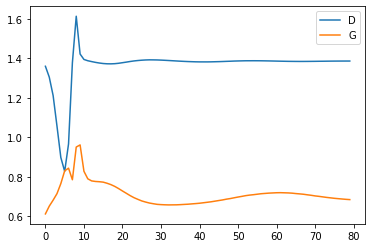

In [28]:
plt.plot(losses_d, label='D')
plt.plot(losses_g, label='G')
plt.legend()
plt.show()

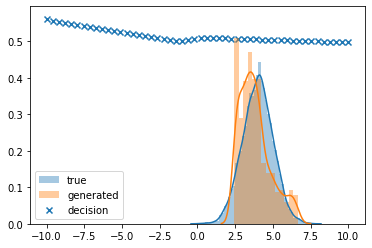

In [29]:
ax = sns.distplot(points.numpy()[:,0], label='true')
x_lin = torch.tensor(np.linspace(-10.0, 10.0, num=50).reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    gen = generator(z_val).numpy()
    dis = discriminator(x_lin).numpy()
bx = sns.distplot(gen[:,0], label='generated')
cx = plt.scatter(x_lin, dis, label='decision', marker='x')
plt.legend()
plt.show()